# R: Impact of 401(k) on Financial Wealth

In this real-data example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the effect of 401(k) eligibility and participation on accumulated assets. The 401(k) data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job. 

## Data

The preprocessed data can be fetched by calling [fetch_401k()](https://docs.doubleml.org/r/stable/reference/fetch_401k.html). The arguments `polynomial_features` and `instrument` can be used to replicate the models used in [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060). Note that an internet connection is required for loading the data. We start with a baseline specification of the regression model and reload the data later in case we want to use another specification.

In [2]:
# Load required packages for this tutorial
library(DoubleML)
library(mlr3)
library(mlr3learners)
library(data.table)
library(ggplot2)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn") 

# load data as a data.table
data = fetch_401k(return_type = "data.table", instrument = TRUE)
dim(data)
str(data)

Warning message:
"package 'mlr3' was built under R version 4.0.5"
Warning message:
"package 'mlr3learners' was built under R version 4.0.5"


[1] 9915   12

Classes 'data.table' and 'data.frame':	9915 obs. of  12 variables:
 $ net_tfa: num  0 1015 -2000 15000 0 ...
 $ age    : num  47 36 37 58 32 34 28 54 43 32 ...
 $ inc    : num  6765 28452 3300 52590 21804 ...
 $ educ   : num  8 16 12 16 11 16 12 11 14 18 ...
 $ fsize  : num  2 1 6 2 1 1 3 3 2 3 ...
 $ marr   : num  0 0 0 1 0 0 1 0 1 1 ...
 $ twoearn: num  0 0 0 1 0 0 1 0 1 0 ...
 $ db     : num  0 0 1 0 0 0 0 0 1 0 ...
 $ pira   : num  0 0 0 0 0 1 1 0 1 0 ...
 $ hown   : num  1 1 0 1 1 1 1 1 1 1 ...
 $ p401   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ e401   : int  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


See the "Details" section on the description of the data set, which can be accessed by typing [help(fetch_401k)](https://docs.doubleml.org/r/stable/reference/fetch_401k.html).

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. 

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

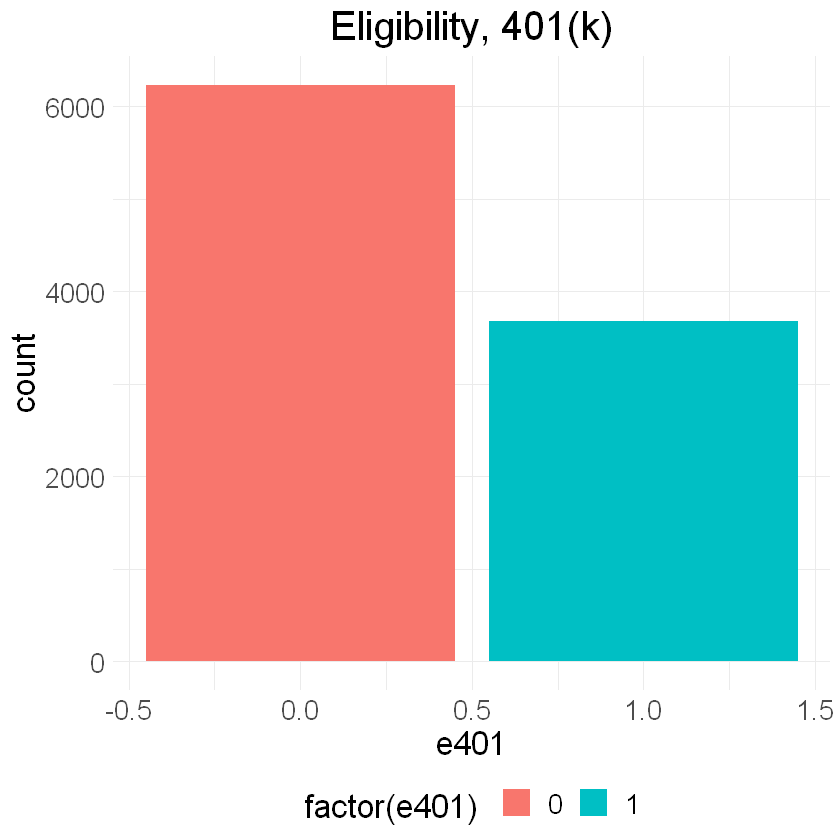

In [3]:
hist_e401 = ggplot(data, aes(x = e401, fill = factor(e401))) +
            geom_bar() + theme_minimal() + 
            ggtitle("Eligibility, 401(k)") +
            theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
                  text = element_text(size = 20)) 
hist_e401

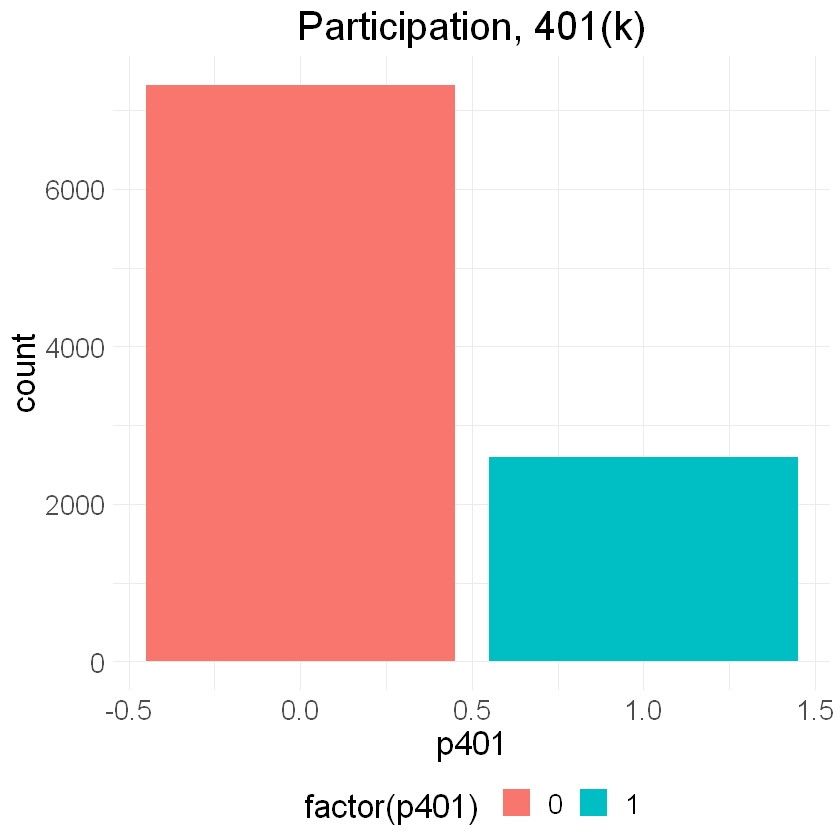

In [4]:
hist_p401 = ggplot(data, aes(x = p401, fill = factor(p401))) +
            geom_bar() + theme_minimal() + 
            ggtitle("Participation, 401(k)") +
            theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
                  text = element_text(size = 20)) 
hist_p401

Eligibility is highly associated with financial wealth:

Warning message:
"Removed 340 rows containing non-finite values (stat_density)."


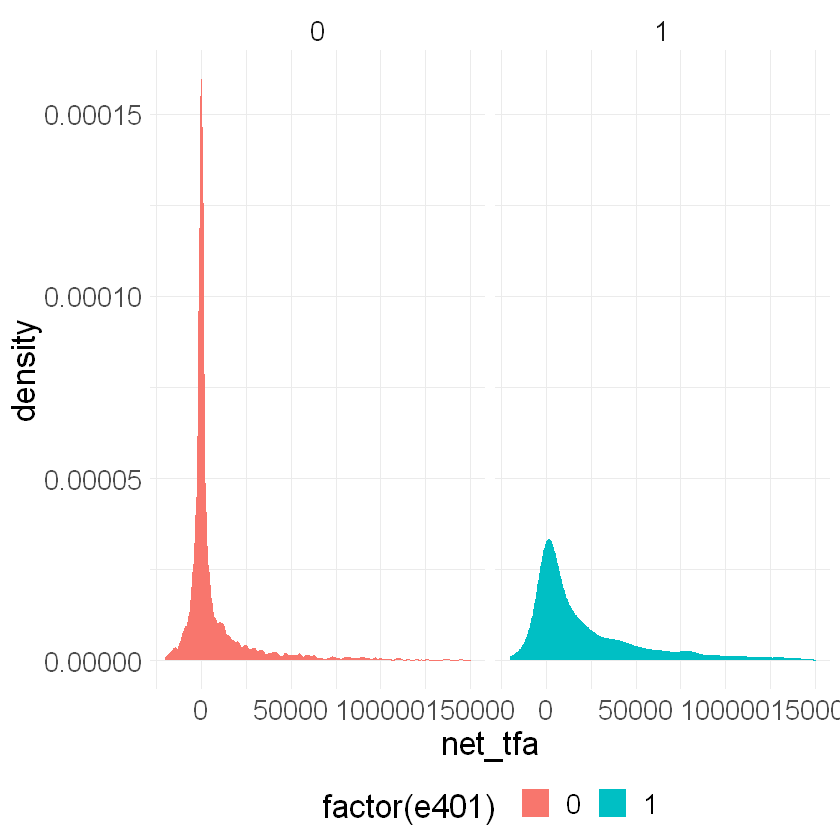

In [5]:
dens_net_tfa = ggplot(data, aes(x = net_tfa, color = factor(e401), fill = factor(e401)) ) + 
                    geom_density() + xlim(c(-20000, 150000)) + 
                    facet_wrap(.~e401)  + theme_minimal() + 
                    theme(legend.position = "bottom", text = element_text(size = 20))
                    
dens_net_tfa

As a first estimate, we calculate the unconditional average predictive effect (APE) of 401(k) eligibility on accumulated assets. This effect corresponds to the average treatment effect if 401(k) eligibility would be assigned to individuals in an entirely randomized way. The unconditional APE of e401 is about $19559$:

In [6]:
APE_e401_uncond = data[e401==1, mean(net_tfa)] - data[e401==0, mean(net_tfa)]
round(APE_e401_uncond, 2)

[1] 19559.34

Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [7]:
APE_p401_uncond = data[p401==1, mean(net_tfa)] - data[p401==0, mean(net_tfa)]
round(APE_p401_uncond, 2)

[1] 27371.58

As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

## The `DoubleML` package

Let's use the package [DoubleML](https://docs.doubleml.org/stable/index.html) to estimate the average treatment effect of 401(k) eligibility, i.e. `e401`, and participation, i.e. `p401`, on net financial assets `net_tfa`.

## Estimating the Average Treatment Effect of 401(k) Eligibility on Net Financial Assets

We first look at the treatment effect of `e401` on net total financial assets. We give estimates of the ATE in the linear model

\begin{equation*}
Y = D \alpha + f(X)'\beta+ \epsilon,
\end{equation*}
where $f(X)$ is a dictonary applied to the raw regressors. $X$ contains variables on marital status, two-earner status, defined benefit pension status, IRA participation, home ownership, family size, education, age, and income. 

In the following, we will consider two different models, 

* a basic model specification that includes the raw regressors, i.e., $f(X) = X$, and 

* a flexible model specification, where $f(X)$ includes the raw regressors $X$ and the orthogonal polynomials of degree 2 for the variables family size education, age, and incuome. 

We will use the basic model specification whenever we use nonlinear methods, for example regression trees or random forests, and use the flexible model for linear methods such as the lasso. There are, of course, multiple ways how the model can be specified even more flexibly, for example including interactions of variable and higher order interaction. However, for the sake of simplicity we stick to the specification above. Users who are interested in varying the model can manipulate the model formula below (`formula_flex`), for example implementing the orignal specification in Chernozhukov et al. (2018). 

In the first step, we report estimates of the average treatment effect (ATE) of 401(k) eligibility on net financial assets both in the partially linear regression (PLR) model and in the interactive regression model (IRM) allowing for heterogeneous treatment effects. 


### The Data Backend: `DoubleMLData`

To start our analysis, we initialize the data backend, i.e., a new instance of a [DoubleMLData](https://docs.doubleml.org/r/stable/reference/DoubleMLData.html) object. Here, we manually implement the regression model by using R's formula interface. A shortcut would be to directly specify the options `polynomial_features` and `instrument` when calling [fetch_401k()](https://docs.doubleml.org/r/stable/reference/fetch_401k.html).$^{**}$

To implement both models (basic and flexible), we generate two data backends: `data_dml_base` and `data_dml_flex`.

$^{**}$ Note that the model specification using `polynomial_features` differs from the one used in our example. 

In [8]:
# Set up basic model: Specify variables for data-backend
features_base = c("age", "inc", "educ", "fsize",
                  "marr", "twoearn", "db", "pira", "hown")

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = DoubleMLData$new(data,
                                 y_col = "net_tfa",
                                 d_cols = "e401",
                                 x_cols = features_base)
data_dml_base

<DoubleMLData>
  Public:
    all_variables: net_tfa age inc educ fsize marr twoearn db pira hown p40 ...
    clone: function (deep = FALSE) 
    d_cols: e401
    data: data.table, data.frame
    data_model: data.table, data.frame
    initialize: function (data = NULL, x_cols = NULL, y_col = NULL, d_cols = NULL, 
    n_instr: 0
    n_obs: 9915
    n_treat: 1
    other_treat_cols: NULL
    set_data_model: function (treatment_var) 
    treat_col: e401
    use_other_treat_as_covariate: TRUE
    x_cols: age inc educ fsize marr twoearn db pira hown
    y_col: net_tfa
    z_cols: NULL
  Private:
    check_disjoint_sets: function () 

In [9]:
# Set up a model according to regression formula with polynomials
formula_flex = formula(" ~ -1 + poly(age, 2, raw=TRUE) +
                        poly(inc, 2, raw=TRUE) + poly(educ, 2, raw=TRUE) +
                        poly(fsize, 2, raw=TRUE) + marr + twoearn +
                        db + pira + hown")
features_flex = data.frame(model.matrix(formula_flex, data))

model_data = data.table("net_tfa" = data[, net_tfa],
                        "e401" = data[, e401],
                        features_flex)

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_flex = DoubleMLData$new(model_data,
                                 y_col = "net_tfa",
                                 d_cols = "e401")

data_dml_flex

<DoubleMLData>
  Public:
    all_variables: net_tfa e401 poly.age..2..raw...TRUE.1 poly.age..2..raw. ...
    clone: function (deep = FALSE) 
    d_cols: e401
    data: data.table, data.frame
    data_model: data.table, data.frame
    initialize: function (data = NULL, x_cols = NULL, y_col = NULL, d_cols = NULL, 
    n_instr: 0
    n_obs: 9915
    n_treat: 1
    other_treat_cols: NULL
    set_data_model: function (treatment_var) 
    treat_col: e401
    use_other_treat_as_covariate: TRUE
    x_cols: poly.age..2..raw...TRUE.1 poly.age..2..raw...TRUE.2 poly ...
    y_col: net_tfa
    z_cols: NULL
  Private:
    check_disjoint_sets: function () 

### Partially Linear Regression Model (PLR)

We start using lasso to estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{eqnarray}
& Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\
& D = m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{eqnarray}

To estimate the causal parameter $\theta_0$ here, we use double machine learning with 3-fold cross-fitting. 
 
Estimation of the nuisance components $g_0$ and $m_0$, is based on the lasso with cross-validated choice of the penalty term , $\lambda$, as provided by the [glmnet package](https://glmnet.stanford.edu/reference/cv.glmnet.html). We load the learner by using the [mlr3](https://mlr3.mlr-org.com/) function [lrn()](https://mlr3.mlr-org.com/reference/Learner.html). Hyperparameters and options can be set during instantiation of the learner. Here we specify that the lasso should use that value of $\lambda$ that minimizes the cross-validated mean squared error which is based on 5-fold cross validation.

In order to use a learner, the underlying R packages have to be installed. In this case, the package [glmnet package](https://glmnet.stanford.edu/reference/cv.glmnet.html) needs to be installed. Moreover, installation of the package [mlr3learners](https://mlr3learners.mlr-org.com/) is required.

We start by estimation the ATE in the basic model and then repeat the estimation in the flexible model.

In [10]:
# Initialize learners
set.seed(123)
lasso = lrn("regr.cv_glmnet", nfolds = 5, s = "lambda.min")
lasso_class = lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

# Initialize DoubleMLPLR model
dml_plr_lasso = DoubleMLPLR$new(data_dml_base, 
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)
dml_plr_lasso$fit()
dml_plr_lasso$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      6133       1465   4.185 2.85e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [11]:
# Initialize learners
set.seed(123)
lasso = lrn("regr.cv_glmnet", nfolds = 5, s = "lambda.min")
lasso_class = lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

# Initialize DoubleMLPLR model
dml_plr_lasso = DoubleMLPLR$new(data_dml_flex, 
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)
dml_plr_lasso$fit()
dml_plr_lasso$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      9580       1325   7.229 4.87e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




Alternatively, we can repeat this procedure with other machine learning methods, for example a random forest learner as provided by the [ranger](https://github.com/imbs-hl/ranger) package for R. The website of the [mlr3extralearners](https://mlr3extralearners.mlr-org.com/articles/learners/list_learners.html) package has a searchable list of all learners that are available in the [mlr3verse](https://mlr3verse.mlr-org.com/).

In [12]:
# Random Forest
randomForest = lrn("regr.ranger", max.depth = 7,
                   mtry = 3, min.node.size = 3)
randomForest_class = lrn("classif.ranger", max.depth = 5,
                         mtry = 4, min.node.size = 7)

set.seed(123)
dml_plr_forest = DoubleMLPLR$new(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_plr_forest$fit() 
dml_plr_forest$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      9127       1313   6.952 3.61e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




Now, let's use a regression tree as provided by the R package [rpart](https://github.com/bethatkinson/rpart).

In [13]:
# Trees
trees = lrn("regr.rpart", cp = 0.0047, minsplit = 203)
trees_class = lrn("classif.rpart", cp = 0.0042, minsplit = 104)

set.seed(123)
dml_plr_tree = DoubleMLPLR$new(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_plr_tree$fit()
dml_plr_tree$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8210       1324   6.203 5.55e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




We can also experiment with extreme gradient boosting as provided by [xgboost](https://xgboost.readthedocs.io/en/latest/).

In [14]:
# Boosted trees
boost = lrn("regr.xgboost",
            objective = "reg:squarederror",
            eta = 0.1, nrounds = 35)
boost_class = lrn("classif.xgboost",
                  objective = "binary:logistic", eval_metric = "logloss",
                  eta = 0.1, nrounds = 34)

set.seed(123)
dml_plr_boost = DoubleMLPLR$new(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost$fit()
dml_plr_boost$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8700       1360   6.399 1.57e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




Let's sum up the results:

In [15]:
confints = rbind(dml_plr_lasso$confint(), dml_plr_forest$confint(),
                 dml_plr_tree$confint(), dml_plr_boost$confint())
estimates = c(dml_plr_lasso$coef, dml_plr_forest$coef,
              dml_plr_tree$coef, dml_plr_boost$coef)
result_plr = data.table("model" = "PLR", 
                        "ML" = c("glmnet", "ranger", "rpart", "xgboost"), 
                        "Estimate" = estimates,
                        "lower" = confints[,1],
                        "upper" = confints[,2])
result_plr

model,ML,Estimate,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
PLR,glmnet,9579.771,6982.443,12177.10
PLR,ranger,9126.999,6553.684,11700.31
PLR,rpart,8209.737,5615.525,10803.95
PLR,xgboost,8700.134,6035.281,11364.99


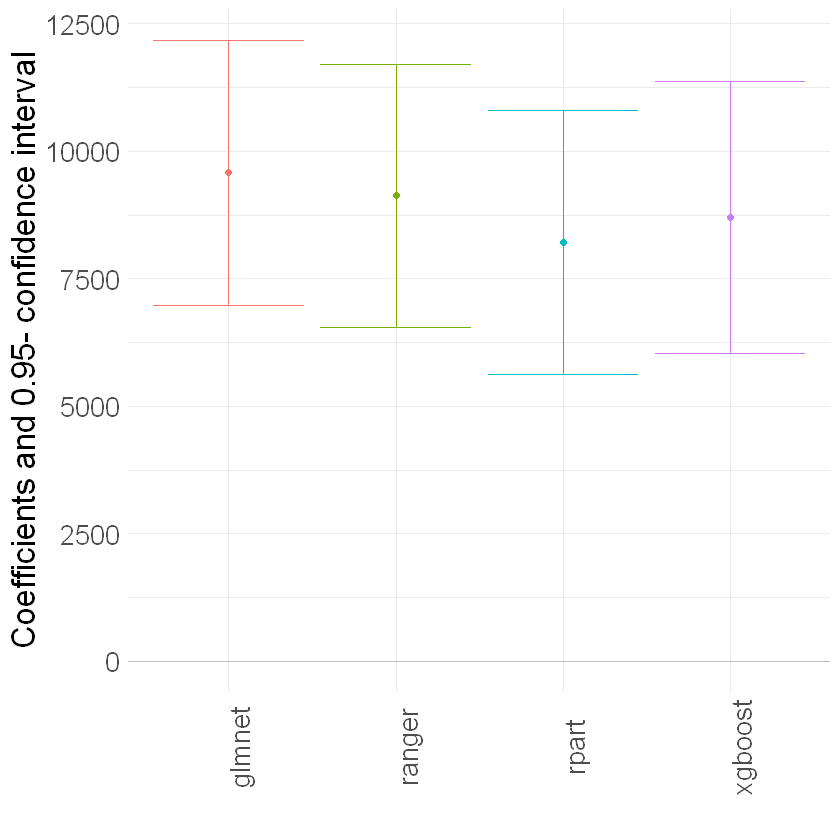

In [16]:
g_ci = ggplot(result_plr, aes(x = ML, y = Estimate, color = ML)) + 
        geom_point() +
        geom_errorbar(aes(ymin = lower, ymax = upper, color = ML))  +
        geom_hline(yintercept = 0, color = "grey") +
        theme_minimal() + ylab("Coefficients and 0.95- confidence interval") + 
        xlab("") + 
        theme(axis.text.x = element_text(angle = 90), legend.position = "none",
              text = element_text(size = 20))

g_ci

### Interactive Regression Model (IRM)

Next, we consider estimation of average treatment effects when treatment effects are fully heterogeneous:

\begin{eqnarray}
& Y = g_0(D,X) + U, &\quad E[U\mid X,D] = 0,\\
& D = m_0(X) + V, &\quad E[V\mid X] = 0.
\end{eqnarray}

To reduce the disproportionate impact of extreme propensity score weights in the interactive model
we trim the propensity scores which are close to the bounds.

In [17]:
set.seed(123)
# Initialize DoubleMLIRM model
dml_irm_lasso = DoubleMLIRM$new(data_dml_flex,
                                ml_g = lasso,
                                ml_m = lasso_class,
                                trimming_threshold = 0.01,
                                n_folds = 3)
dml_irm_lasso$fit()
dml_irm_lasso$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8850       1341   6.601 4.08e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [18]:
# Initialize Learner
randomForest = lrn("regr.ranger")
randomForest_class = lrn("classif.ranger")

# Random Forest
set.seed(123)
dml_irm_forest = DoubleMLIRM$new(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.01,
                                 n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_forest$set_ml_nuisance_params(
    "ml_g0", "e401", list(max.depth = 6, mtry = 4, min.node.size = 7))
dml_irm_forest$set_ml_nuisance_params(
    "ml_g1", "e401", list(max.depth = 6, mtry = 3, min.node.size = 5))
dml_irm_forest$set_ml_nuisance_params(
    "ml_m", "e401", list(max.depth = 6, mtry = 3, min.node.size = 6))

dml_irm_forest$fit()
dml_irm_forest$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8202       1118   7.334 2.23e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [18]:
# Initialize Learner
trees = lrn("regr.rpart")
trees_class = lrn("classif.rpart")

# Trees
set.seed(123)
dml_irm_tree = DoubleMLIRM$new(data_dml_base,
                          ml_g = trees,
                          ml_m = trees_class,
                          trimming_threshold = 0.01,
                          n_folds = 3)

# Set nuisance-part specific parameters
dml_irm_tree$set_ml_nuisance_params(
    "ml_g0", "e401", list(cp = 0.0016, minsplit = 74))
dml_irm_tree$set_ml_nuisance_params(
    "ml_g1", "e401", list(cp = 0.0018, minsplit = 70))
dml_irm_tree$set_ml_nuisance_params(
    "ml_m", "e401", list(cp = 0.0028, minsplit = 167))

dml_irm_tree$fit()
dml_irm_tree$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8415       1186   7.098 1.26e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [19]:
# Initialize Learners
boost = lrn("regr.xgboost", objective = "reg:squarederror")
boost_class = lrn("classif.xgboost", objective = "binary:logistic", eval_metric = "logloss")

# Boosted Trees
set.seed(123)
dml_irm_boost = DoubleMLIRM$new(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                trimming_threshold = 0.01,
                                n_folds = 3)

# Set nuisance-part specific parameters
if (compareVersion(as.character(packageVersion("DoubleML")), "0.2.1") > 0) {
    dml_irm_boost$set_ml_nuisance_params(
        "ml_g0", "e401", list(nrounds = 8, eta = 0.1))
    dml_irm_boost$set_ml_nuisance_params(
        "ml_g1", "e401", list(nrounds = 29, eta = 0.1))
    dml_irm_boost$set_ml_nuisance_params(
        "ml_m", "e401", list(nrounds = 23, eta = 0.1))
} else {
    # behavior of set_ml_nuisance_params() changed in https://github.com/DoubleML/doubleml-for-r/pull/89
    dml_irm_boost$set_ml_nuisance_params(
        "ml_g0", "e401", list(nrounds = 8, eta = 0.1, objective = "reg:squarederror", verbose=0))
    dml_irm_boost$set_ml_nuisance_params(
        "ml_g1", "e401", list(nrounds = 29, eta = 0.1, objective = "reg:squarederror", verbose=0))
    dml_irm_boost$set_ml_nuisance_params(
        "ml_m", "e401", list(nrounds = 23, eta = 0.1, objective = "binary:logistic", eval_metric = "logloss", verbose=0))
}

dml_irm_boost$fit()
dml_irm_boost$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
e401      8048       1182   6.808 9.91e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




model,ML,Estimate,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
IRM,glmnet,8850.064,6222.396,11477.73
IRM,ranger,8202.101,6010.245,10393.96
IRM,rpart,8415.276,6091.618,10738.93
IRM,xgboost,8047.598,5730.684,10364.51


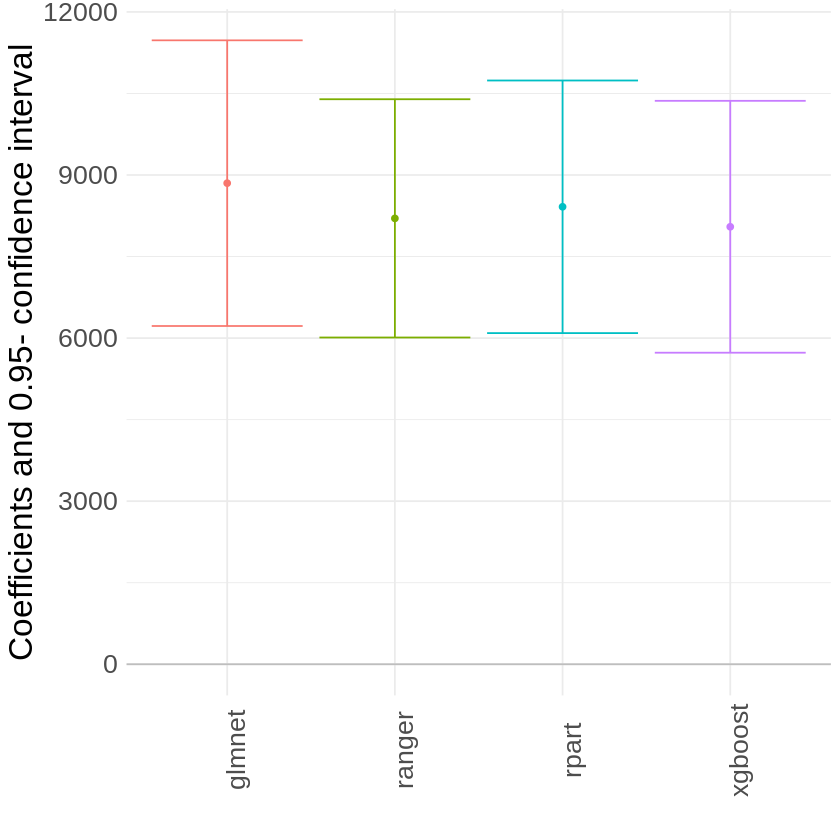

In [20]:
confints = rbind(dml_irm_lasso$confint(), dml_irm_forest$confint(),
                 dml_irm_tree$confint(), dml_irm_boost$confint())
estimates = c(dml_irm_lasso$coef, dml_irm_forest$coef,
              dml_irm_tree$coef, dml_irm_boost$coef)
result_irm = data.table("model" = "IRM", 
                        "ML" = c("glmnet", "ranger", "rpart", "xgboost"), 
                        "Estimate" = estimates,
                        "lower" = confints[,1],
                        "upper" = confints[,2])
result_irm

g_ci = ggplot(result_irm, aes(x = ML, y = Estimate, color = ML)) + 
        geom_point() +
        geom_errorbar(aes(ymin = lower, ymax = upper, color = ML))  +
        geom_hline(yintercept = 0, color = "grey") +
        theme_minimal() + ylab("Coefficients and 0.95- confidence interval") + 
        xlab("") + 
        theme(axis.text.x = element_text(angle = 90), legend.position = "none",
              text = element_text(size = 20))

g_ci

These estimates that flexibly account for confounding are
substantially attenuated relative to the baseline estimate (*19559*) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings. The best model with lowest RMSE in both equations is the PLR model estimated via lasso. It gives the following estimate:

## Local Average Treatment Effects of 401(k) Participation on Net Financial Assets

### Interactive IV Model (IIVM)

In the examples above, we estimated the average treatment effect of *eligibility* on financial asset holdings. Now, we consider estimation of local average treatment effects (LATE) of *participation* using eligibility as an instrument for the participation decision. Under appropriate assumptions, the LATE identifies the treatment effect for so-called compliers, i.e., individuals who would only participate if eligible and otherwise not participate in the program. 

As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates. We use `e401` as a binary instrument for the treatment variable `p401`. Here the structural equation model is:

\begin{eqnarray}
& Y = g_0(Z,X) + U, &\quad E[U\mid Z,X] = 0,\\
& D = r_0(Z,X) + V, &\quad E[V\mid Z, X] = 0,\\
& Z = m_0(X) + \zeta, &\quad E[\zeta \mid X] = 0.
\end{eqnarray}

In [21]:
# Initialize DoubleMLData with an instrument

# Basic model
data_dml_base_iv = DoubleMLData$new(data,
                                    y_col = "net_tfa",
                                    d_cols = "p401",
                                    x_cols = features_base,
                                    z_cols = "e401")
data_dml_base_iv

<DoubleMLData>
  Public:
    all_variables: net_tfa age inc educ fsize marr twoearn db pira hown p40 ...
    clone: function (deep = FALSE) 
    d_cols: p401
    data: data.table, data.frame
    data_model: data.table, data.frame
    initialize: function (data = NULL, x_cols = NULL, y_col = NULL, d_cols = NULL, 
    n_instr: 1
    n_obs: 9915
    n_treat: 1
    other_treat_cols: NULL
    set_data_model: function (treatment_var) 
    treat_col: p401
    use_other_treat_as_covariate: TRUE
    x_cols: age inc educ fsize marr twoearn db pira hown
    y_col: net_tfa
    z_cols: e401

In [22]:
# Flexible model
model_data = data.table("net_tfa" = data[, net_tfa],
                        "e401" = data[, e401],
                        "p401" = data[, p401],
                        features_flex)
data_dml_flex_iv = DoubleMLData$new(model_data,
                                    y_col = "net_tfa",
                                    d_cols = "p401",
                                    z_cols = "e401")

In [23]:
set.seed(123)
dml_iivm_lasso = DoubleMLIIVM$new(data_dml_flex_iv,
                                  ml_g = lasso, 
                                  ml_m = lasso_class,
                                  ml_r = lasso_class,
                                  n_folds = 3,
                                  trimming_threshold = 0.01,
                                  subgroups = list(always_takers = FALSE,
                                                   never_takers = TRUE))
dml_iivm_lasso$fit()
dml_iivm_lasso$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
p401     12802       1941   6.597  4.2e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




Again, we repeat the procedure for the other machine learning methods:

In [24]:
# Initialize Learner
randomForest = lrn("regr.ranger")
randomForest_class = lrn("classif.ranger")

# Random Forest
set.seed(123)
dml_iivm_forest = DoubleMLIIVM$new(data_dml_base_iv,
                              ml_g = randomForest, 
                              ml_m = randomForest_class,
                              ml_r = randomForest_class,
                              n_folds = 3,
                              trimming_threshold = 0.01,
                              subgroups = list(always_takers = FALSE,
                                               never_takers = TRUE))

# Set nuisance-part specific parameters
dml_iivm_forest$set_ml_nuisance_params(
    "ml_g0", "p401",
    list(max.depth = 6, mtry = 4, min.node.size = 7))
dml_iivm_forest$set_ml_nuisance_params(
    "ml_g1", "p401", 
    list(max.depth = 6, mtry = 3, min.node.size = 5))
dml_iivm_forest$set_ml_nuisance_params(
    "ml_m", "p401",
    list(max.depth = 6, mtry = 3, min.node.size = 6))
dml_iivm_forest$set_ml_nuisance_params(
    "ml_r1", "p401",
    list(max.depth = 4, mtry = 7, min.node.size = 6))

dml_iivm_forest$fit()
dml_iivm_forest$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
p401     11792       1604   7.352 1.95e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [25]:
# Initialize Learner
trees = lrn("regr.rpart")
trees_class = lrn("classif.rpart")

# Trees
set.seed(123)
dml_iivm_tree = DoubleMLIIVM$new(data_dml_base_iv,
                                 ml_g = trees, 
                                 ml_m = trees_class,
                                 ml_r = trees_class,
                                 n_folds = 3,
                                 trimming_threshold = 0.01,
                                 subgroups = list(always_takers = FALSE,
                                                  never_takers = TRUE))

# Set nuisance-part specific parameters
dml_iivm_tree$set_ml_nuisance_params(
    "ml_g0", "p401",
    list(cp = 0.0016, minsplit = 74))
dml_iivm_tree$set_ml_nuisance_params(
    "ml_g1", "p401",
    list(cp = 0.0018, minsplit = 70))
dml_iivm_tree$set_ml_nuisance_params(
    "ml_m", "p401",
    list(cp = 0.0028, minsplit = 167))
dml_iivm_tree$set_ml_nuisance_params(
    "ml_r1", "p401",
    list(cp = 0.0576, minsplit = 55))

dml_iivm_tree$fit()
dml_iivm_tree$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
p401     12214       1714   7.128 1.02e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




In [26]:
# Initialize Learner
boost = lrn("regr.xgboost", objective = "reg:squarederror")
boost_class = lrn("classif.xgboost", objective = "binary:logistic", eval_metric = "logloss")

# Boosted Trees
set.seed(123)
dml_iivm_boost = DoubleMLIIVM$new(data_dml_base_iv,
                              ml_g = boost, 
                              ml_m = boost_class,
                              ml_r = boost_class,
                              n_folds = 3,
                              trimming_threshold = 0.01,
                              subgroups = list(always_takers = FALSE,
                                               never_takers = TRUE))

# Set nuisance-part specific parameters
if (compareVersion(as.character(packageVersion("DoubleML")), "0.2.1") > 0) {
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_g0", "p401",
        list(nrounds = 9, eta = 0.1))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_g1", "p401",
        list(nrounds = 33, eta = 0.1))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_m", "p401",
        list(nrounds = 12, eta = 0.1))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_r1", "p401",
        list(nrounds = 25, eta = 0.1))
} else {
    # behavior of set_ml_nuisance_params() changed in https://github.com/DoubleML/doubleml-for-r/pull/89
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_g0", "p401",
        list(nrounds = 9, eta = 0.1, objective = "reg:squarederror", verbose=0))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_g1", "p401",
        list(nrounds = 33, eta = 0.1, objective = "reg:squarederror", verbose=0))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_m", "p401",
        list(nrounds = 12, eta = 0.1, objective = "binary:logistic", eval_metric = "logloss", verbose=0))
    dml_iivm_boost$set_ml_nuisance_params(
        "ml_r1", "p401",
        list(nrounds = 25, eta = 0.1, objective = "binary:logistic", eval_metric = "logloss", verbose=0))
}

dml_iivm_boost$fit()
dml_iivm_boost$summary()

[1] "Estimates and significance testing of the effect of target variables"
     Estimate. Std. Error t value Pr(>|t|)    
p401     11861       1619   7.324  2.4e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1




model,ML,Estimate,lower,upper
<chr>,<chr>,<dbl>,<dbl>,<dbl>
IIVM,glmnet,12802.26,8998.639,16605.88
IIVM,ranger,11792.22,8648.579,14935.87
IIVM,rpart,12214.45,8855.864,15573.04
IIVM,xgboost,11861.19,8687.158,15035.22


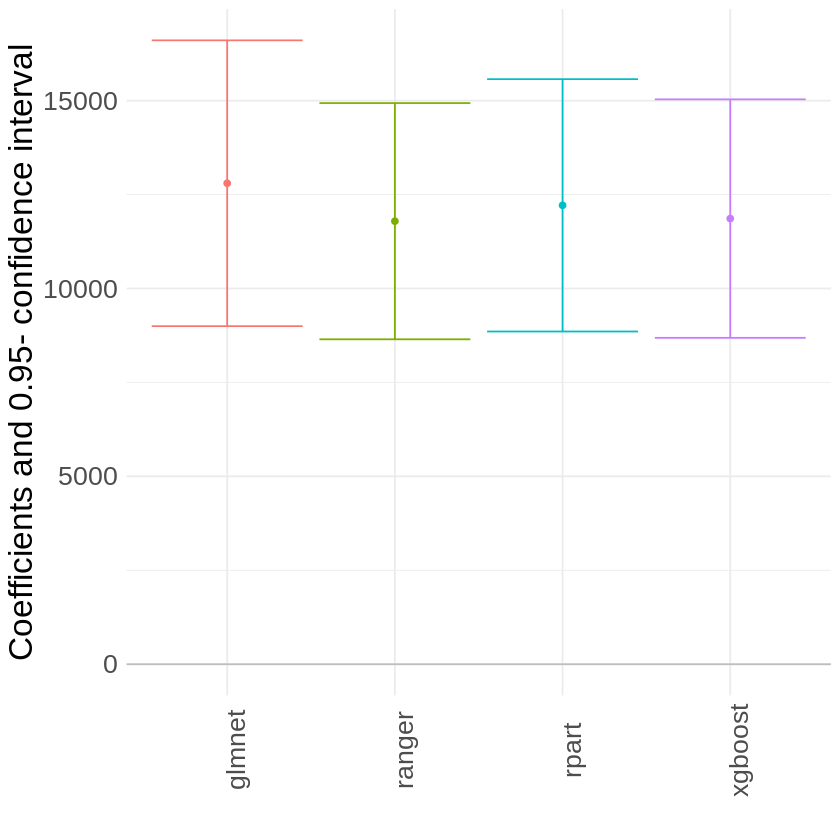

In [27]:
confints = rbind(dml_iivm_lasso$confint(), dml_iivm_forest$confint(),
                 dml_iivm_tree$confint(), dml_iivm_boost$confint())
estimates = c(dml_iivm_lasso$coef, dml_iivm_forest$coef,
              dml_iivm_tree$coef, dml_iivm_boost$coef)
result_iivm = data.table("model" = "IIVM", 
                        "ML" = c("glmnet", "ranger", "rpart", "xgboost"), 
                        "Estimate" = estimates,
                        "lower" = confints[,1],
                        "upper" = confints[,2])
result_iivm

g_ci = ggplot(result_iivm, aes(x = ML, y = Estimate, color = ML)) + 
        geom_point() +
        geom_errorbar(aes(ymin = lower, ymax = upper, color = ML))  +
        geom_hline(yintercept = 0, color = "grey") +
        theme_minimal() + ylab("Coefficients and 0.95- confidence interval") + 
        xlab("") + 
        theme(axis.text.x = element_text(angle = 90), legend.position = "none",
              text = element_text(size = 20))

g_ci

## Summary of Results

To sum up, let's merge all our results so far and illustrate them in a plot. 

In [28]:
summary_result = rbindlist(list(result_plr, result_irm, result_iivm))
summary_result[, model := factor(model, levels = c("PLR", "IRM", "IIVM"))]

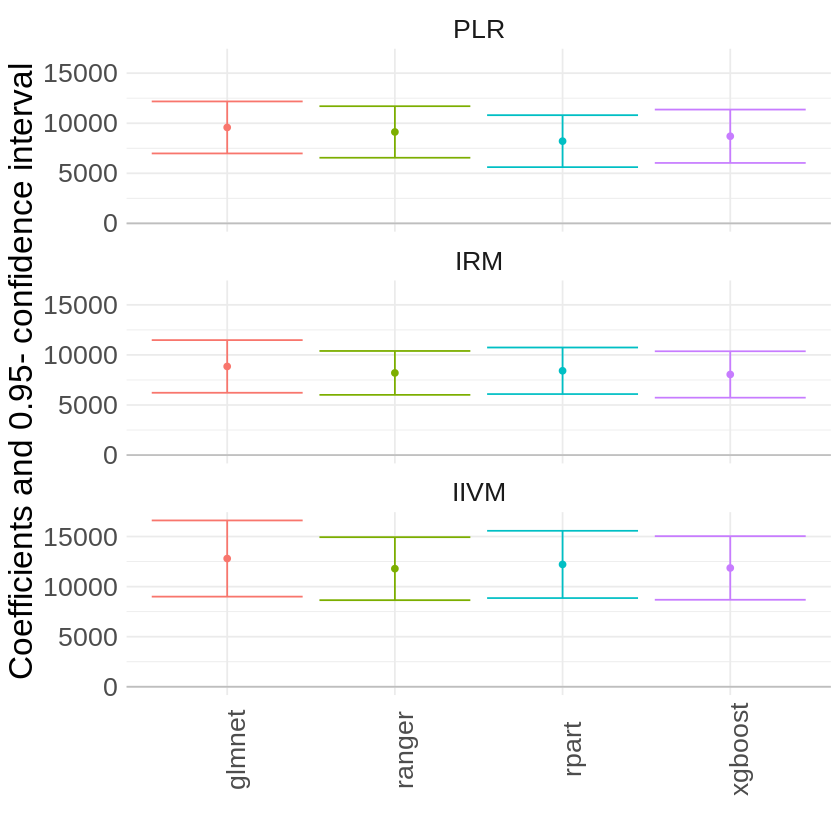

In [29]:
g_all = ggplot(summary_result, aes(x = ML, y = Estimate, color = ML)) + 
        geom_point() +
        geom_errorbar(aes(ymin = lower, ymax = upper, color = ML))  +
        geom_hline(yintercept = 0, color = "grey") +
        theme_minimal() + ylab("Coefficients and 0.95- confidence interval") + 
        xlab("") + 
        theme(axis.text.x = element_text(angle = 90), legend.position = "none",
              text = element_text(size = 20)) + 
        facet_wrap(model ~., ncol = 1)

g_all

We report results based on four ML methods for estimating the nuisance functions used in
forming the orthogonal estimating equations. We find again that the estimates of the treatment effect are stable across ML methods. The estimates are highly significant, hence we would reject the hypothesis
that 401(k) participation has no effect on financial wealth.

______

**Acknowledgement**

We would like to thank [Jannis Kueck](https://www.bwl.uni-hamburg.de/en/statistik/team/kueck.html) for sharing [the kaggle notebook](https://www.kaggle.com/janniskueck/pm5-401k). The pension data set has been analyzed in several studies, among others [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060).

